# Initial Setups

## (Google Colab use only)

In [1]:
# Use Google Colab
use_colab = False

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')

    # cd to the appropriate working directory under my Google Drive
    %cd '/content/drive/My Drive/cs696ds_lexalytics/Prompting Experiments'
    
    # Install packages specified in requirements
    !pip install -r requirements.txt
    
    # List the directory contents
    !ls

## Experiment parameters

In [2]:

# We will use the following string ID to identify this particular (training) experiments
# in directory paths and other settings
experiment_id = 'supervised_nli_single_prompt_1_in_domain_restaurant_MNLI_base_seed_696'

# Random seed
random_seed = 696

# path to pretrained nli model folder or the string "textattack/bert-base-uncased-MNLI"
nli_model_path = "textattack/bert-base-uncased-MNLI"

# Prompts to be added to the end of each review text
sentiment_prompts = [
    "The {aspect} is good.",
    "The {aspect} is bad."]

#index of the prompts in the sentiment_prompts by polarity for later grouping
pos_prompt_indexes = [0]
neg_prompt_indexes = [1]

#What datasets to be used for training and testing loops
training_domain = "restaurants"
testing_domain = "restaurants"

# Training settings
training_epochs = 20
training_batch_size = 8
training_learning_rate = 2e-5
training_weight_decay = 0.01
training_warmup_steps_duration = 0.1
training_best_model_criterion = 'train_loss'

training_lm_freeze = False

validation_enabled = False
validation_dataset_proportion = 0.2
validation_batch_size = 8

testing_batch_size = 32
sample_size = 256

In [3]:
# Parameters
experiment_id = "nli_few_shot_in_domain_restaurants_16_MNLI-base_made_me_feel_696"
random_seed = 696
nli_model_path = "textattack/bert-base-uncased-MNLI"
sentiment_prompts = [
    "The {aspect} made me feel good.",
    "The {aspect} made me feel bad.",
]
pos_prompt_indexes = [0]
neg_prompt_indexes = [1]
training_domain = "restaurants"
testing_batch_size = 8
testing_domain = "restaurants"
training_batch_size = 8
sample_size = 16


## Package imports

In [4]:
import sys
import os
import random
import shutil
import copy
import inspect

import numpy as np
import torch
import transformers
import datasets
import sklearn.metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tqdm

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import utils

# Random seed settings
random.seed(random_seed)
np.random.seed(random_seed)
# cuBLAS reproducibility
# https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"
torch.set_deterministic(True)
torch.manual_seed(random_seed)

# Print version information
print("Python version: " + sys.version)
print("NumPy version: " + np.__version__)
print("PyTorch version: " + torch.__version__)
print("Transformers version: " + transformers.__version__)

Python version: 3.6.13 |Anaconda, Inc.| (default, Feb 23 2021, 21:15:04) 
[GCC 7.3.0]
NumPy version: 1.19.5
PyTorch version: 1.7.1
Transformers version: 4.3.3


## PyTorch GPU settings

In [5]:

if torch.cuda.is_available():    
    torch_device = torch.device('cuda')

    # Set this to True to make your output immediately reproducible
    # Note: https://pytorch.org/docs/stable/notes/randomness.html
    torch.backends.cudnn.deterministic = True
    
    # Disable 'benchmark' mode: Set this False if you want to measure running times more fairly
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    
    # Faster Host to GPU copies with page-locked memory
    use_pin_memory = True
    
    # Number of compute devices to be used for training
    training_device_count = torch.cuda.device_count()

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
    print("Number of CUDA devices: "+ str(training_device_count))
    
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False
    
    # Number of compute devices to be used for training
    training_device_count = 1

print()
print("PyTorch device selected:", torch_device)

CUDA Version: 10.2
cuDNN Version: 7605
CUDA Device Name: GeForce GTX TITAN X
CUDA Capabilities: (5, 2)
Number of CUDA devices: 1

PyTorch device selected: cuda


# Prepare Datasets for Prompt-based Classifier

## Load the SemEval dataset

In [6]:
# Load semeval for both domains
laptop_semeval_dataset = datasets.load_dataset(
    os.path.abspath('../dataset_scripts/semeval2014_task4/semeval2014_task4.py'),
    data_files={
        'test': '../dataset_files/semeval_2014/Laptops_Test_Gold.xml',
        'train': '../dataset_files/semeval_2014/Laptop_Train_v2.xml',
    },
    cache_dir='../dataset_cache')

restaurant_semeval_dataset = datasets.load_dataset(
    os.path.abspath('../dataset_scripts/semeval2014_task4/semeval2014_task4.py'),
    data_files={
        'test': '../dataset_files/semeval_2014/Restaurants_Test_Gold.xml',
        'train': '../dataset_files/semeval_2014/Restaurants_Train_v2.xml',
    },
    cache_dir='../dataset_cache')

Using custom data configuration default


Reusing dataset sem_eval2014_task4_dataset (../dataset_cache/sem_eval2014_task4_dataset/default-c1bed44099ac1808/0.0.1/f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969)


Using custom data configuration default


Reusing dataset sem_eval2014_task4_dataset (../dataset_cache/sem_eval2014_task4_dataset/default-f64bbd4736fb4267/0.0.1/f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969)


In [7]:
dataset_dic_train = {
    "laptops": laptop_semeval_dataset['train'],
    "restaurants": restaurant_semeval_dataset['train']
}

dataset_dic_test = {
    "laptops": laptop_semeval_dataset['test'],
    "restaurants": restaurant_semeval_dataset['test']
}


In [8]:
# The dataset chosen for training and testing
train_set = dataset_dic_train[training_domain]
test_set = dataset_dic_test[testing_domain]


#Shuffle and select 256
train_set = train_set.shuffle(seed=random_seed)
train_set = train_set.select(range(sample_size))

Loading cached shuffled indices for dataset at ../dataset_cache/sem_eval2014_task4_dataset/default-f64bbd4736fb4267/0.0.1/f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969/cache-018db51f6b614634.arrow


## Train-validation split

In [9]:
# Training set size after validation split
if validation_enabled:
    new_train_dataset_size = int(len(train_set) * (1 - validation_dataset_proportion))
    new_valid_dataset_size = len(train_set) - new_train_dataset_size
    print("Training dataset after split:", new_train_dataset_size)
    print("Validation dataset after split:", new_train_dataset_size)
else:
    new_train_dataset_size = len(train_set)
    print("Training dataset size:", new_train_dataset_size)

Training dataset size: 16


In [10]:
train_set = train_set.shuffle(seed=random_seed)

new_train_set = train_set.select(indices=np.arange(new_train_dataset_size))

if validation_enabled:
    new_valid_set = train_set.select(
        indices=np.arange(
            new_train_dataset_size,
            new_train_dataset_size + new_valid_dataset_size))

Loading cached shuffled indices for dataset at ../dataset_cache/sem_eval2014_task4_dataset/default-f64bbd4736fb4267/0.0.1/f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969/cache-af375eb00b8f0457.arrow


In [11]:
print(new_train_set[0])

{'aspect': 'atmosphere', 'sentiment': 0, 'text': 'But the best part about LS is the late night atmosphere, delightfully free of the BTs.'}


# Supervised ATSC with Prompts + Logistic Regression Head

## Load the pretrained LM

In [12]:
# Load pretrained language model
nli_model = transformers.AutoModelForSequenceClassification.from_pretrained(nli_model_path)
tokenizer = transformers.AutoTokenizer.from_pretrained("textattack/bert-base-uncased-MNLI", cache_dir='../bert_base_cache')

In [13]:
# Freeze all layers in lm.
if training_lm_freeze:
    for param in nli_model.parameters():
        param.requires_grad = False

In [14]:
classifier = utils.NLISentimentClassificationHead(
                    nli_model = nli_model,
                    num_prompts = len(sentiment_prompts),
                    pos_prompt_indexes = pos_prompt_indexes,
                    neg_prompt_indexes = neg_prompt_indexes
                    )
classifier.to(torch_device)

NLISentimentClassificationHead(
  (nli_model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_f

## Training settings

In [15]:
# How many training steps would we have?
approx_total_training_steps = len(new_train_set) // training_batch_size * training_epochs

print("There will be approximately %d training steps." % approx_total_training_steps)

# Let's have warmups for the first (training_warmup_steps_duration)% of steps.
training_warmup_steps = int(approx_total_training_steps * training_warmup_steps_duration)

print("Warmup steps:", training_warmup_steps)

There will be approximately 40 training steps.
Warmup steps: 4


In [16]:
train_dataloader = torch.utils.data.DataLoader(
    new_train_set, batch_size=training_batch_size,
    shuffle=True, pin_memory=use_pin_memory)

if validation_enabled:
    validation_dataloader = torch.utils.data.DataLoader(
        new_valid_set, batch_size=validation_batch_size, pin_memory=use_pin_memory)

loss_function = torch.nn.CrossEntropyLoss()

optimizer = transformers.AdamW(
    classifier.parameters(),
    lr=training_learning_rate,
    weight_decay=training_weight_decay)

scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=training_warmup_steps,
    num_training_steps=len(new_train_set) * training_epochs,
)

# The directory to save the best version of the head
trained_model_directory = os.path.join('..', 'trained_models', experiment_id)

shutil.rmtree(trained_model_directory, ignore_errors=True)
os.makedirs(trained_model_directory)

In [17]:
def compute_metrics(predictions, labels):
    preds = predictions.argmax(-1)

    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
        y_true=labels, y_pred=preds, labels=[0,1,2], average='macro')

    acc = sklearn.metrics.accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## Training loop

In [18]:
best_epoch = -1

if training_best_model_criterion in ('train_loss', 'valid_loss'):
    best_score = float('inf')
else:
    best_score = -1

for epoch in tqdm.notebook.tqdm(range(int(training_epochs))):

    print("Training epoch %d" % epoch)
    print()

    classifier.train()

    for batch in tqdm.notebook.tqdm(train_dataloader):

        reviews_repeated = []
        prompts_populated = []

        for i in range(len(batch["text"])):
            
            for prompt in sentiment_prompts:
                reviews_repeated.append(batch["text"][i])
                prompts_populated.append(prompt.format(aspect=batch["aspect"][i]))

        batch_encoded = tokenizer(
            reviews_repeated, prompts_populated,
            padding='max_length', truncation='only_first', max_length=256,
            return_tensors='pt')
        
        batch_encoded = batch_encoded.to(torch_device)
        
        labels = batch["sentiment"]
        labels = labels.to(torch_device)

        optimizer.zero_grad()
        
        outputs = classifier(batch_encoded)
        
        loss = loss_function(outputs, labels)
        
        loss.backward()

        optimizer.step()
        scheduler.step()
        
    print("Epoch {}, Training Loss: {}".format(epoch, loss.item()))
    print()
    
    
    # Validate the model using val dataset
    if validation_enabled:
        with torch.no_grad():
            classifier.eval()

            print("Validation epoch %d" % epoch)
            print()

            predictions_val = torch.Tensor()

            labels_val = torch.Tensor()

            for batch_val in tqdm.notebook.tqdm(validation_dataloader):

                reviews_repeated = []
                prompts_populated = []

            for i in range(len(batch_val["text"])):

                for prompt in sentiment_prompts:
                    reviews_repeated.append(batch_val["text"][i])
                    prompts_populated.append(prompt.format(aspect=batch_val["aspect"][i]))

                batch_encoded = tokenizer(
                    reviews_repeated, prompts_populated,
                    padding='max_length', truncation='only_first', max_length=256,
                    return_tensors='pt')

                batch_encoded.to(torch_device)

                labels = batch["sentiment"]
                labels = labels.to(torch_device)

                optimizer.zero_grad()

                outputs = classifier(batch_encoded)

                outputs = outputs.to('cpu')

                predictions_val = torch.cat([predictions_val, outputs])
                labels_val = torch.cat([labels_val, labels])

            # Compute metrics
            validation_loss = torch.nn.functional.cross_entropy(predictions_val, labels_val.long())

            validation_metrics = compute_metrics(predictions_val, labels_val)

            print("Validation Loss: {}, Validation Metrics: {}".format(validation_loss.item(), validation_metrics))
            print()

    if training_best_model_criterion == 'train_loss':
        epoch_score = loss.item()
    elif training_best_model_criterion == 'valid_loss':
        epoch_score = validation_loss.item()
        
    if training_best_model_criterion in ('train_loss', 'valid_loss'):
        better_model_found = epoch_score < best_score
    else:
        better_model_found = epoch_score > best_score

    # Save the current epoch's model if the validation loss is lower than the best known so far
    if better_model_found:
        if best_epoch != -1:
            try:
                os.remove(os.path.join(trained_model_directory, 'epoch_{}.pt'.format(best_epoch)))
            except:
                pass

        best_score = epoch_score
        best_epoch = epoch

        torch.save(
            classifier.state_dict(),
            os.path.join(trained_model_directory, 'epoch_{}.pt'.format(epoch)))

Training epoch 0




Epoch 0, Training Loss: 2.07584810256958



Training epoch 1




Epoch 1, Training Loss: 0.8304495811462402



Training epoch 2




Epoch 2, Training Loss: 1.2572158575057983

Training epoch 3




Epoch 3, Training Loss: 0.8716126084327698

Training epoch 4




Epoch 4, Training Loss: 0.5057315826416016



Training epoch 5




Epoch 5, Training Loss: 0.37324875593185425



Training epoch 6




Epoch 6, Training Loss: 0.3285846710205078



Training epoch 7




Epoch 7, Training Loss: 0.32856473326683044



Training epoch 8




Epoch 8, Training Loss: 0.25705593824386597



Training epoch 9




Epoch 9, Training Loss: 0.1690971553325653



Training epoch 10




Epoch 10, Training Loss: 0.053822390735149384



Training epoch 11




Epoch 11, Training Loss: 0.08763804286718369

Training epoch 12




Epoch 12, Training Loss: 0.06638725847005844

Training epoch 13




Epoch 13, Training Loss: 0.039667073637247086



Training epoch 14




Epoch 14, Training Loss: 0.04728732630610466

Training epoch 15




Epoch 15, Training Loss: 0.0385100357234478



Training epoch 16




Epoch 16, Training Loss: 0.027730295434594154



Training epoch 17




Epoch 17, Training Loss: 0.020638661459088326



Training epoch 18




Epoch 18, Training Loss: 0.019513724371790886



Training epoch 19




Epoch 19, Training Loss: 0.020729949697852135




## Evaluation with in-domain test set

In [19]:
test_dataloader = torch.utils.data.DataLoader(
    test_set, batch_size=testing_batch_size, pin_memory=use_pin_memory)

In [20]:

# Load the best found head weights
with torch.no_grad():
    print('Loading epoch {}'.format(best_epoch))
    
    classifier.load_state_dict(torch.load(
        os.path.join(trained_model_directory, 'epoch_{}.pt'.format(best_epoch)),
        map_location=torch_device))

    classifier.eval()

    predictions_test = torch.Tensor().to(torch_device)

    labels_test = torch.Tensor().to(torch_device)

    for batch_test in tqdm.notebook.tqdm(test_dataloader):

        reviews_repeated = []
        prompts_populated = []

        for i in range(len(batch_test["text"])):
            
            for prompt in sentiment_prompts:
                reviews_repeated.append(batch_test["text"][i])
                prompts_populated.append(prompt.format(aspect=batch_test["aspect"][i]))

        batch_encoded = tokenizer(
            reviews_repeated, prompts_populated,
            padding='max_length', truncation='only_first', max_length=256,
            return_tensors='pt')
        
        batch_encoded.to(torch_device)

        nli_output = nli_model(**batch_encoded)["logits"]

        labels = batch_test["sentiment"]
        labels = labels.to(torch_device)

        optimizer.zero_grad()
        
        outputs = classifier(batch_encoded)
        
        predictions_test = torch.cat([predictions_test, outputs])
        labels_test = torch.cat([labels_test, labels])

    # Compute metrics
    test_metrics = compute_metrics(predictions_test.cpu(), labels_test.cpu())
    
    print(test_metrics)

Loading epoch 18



{'accuracy': 0.7428571428571429, 'f1': 0.6382601515176706, 'precision': 0.6741452215554307, 'recall': 0.6232993197278912}


## Results visualization

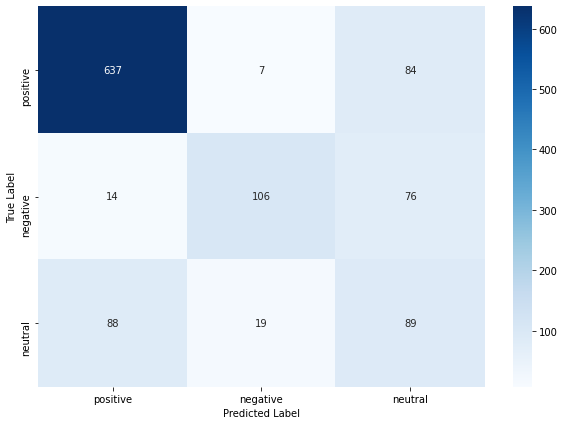

In [21]:
# Calculate metrics and confusion matrix based upon predictions and true labels
cm = sklearn.metrics.confusion_matrix(labels_test.cpu().detach().numpy(), predictions_test.cpu().detach().numpy().argmax(-1), labels=[0,1,2])

df_cm = pd.DataFrame(
    cm,
    index=[i for i in ["positive", "negative", "neutral"]],
    columns=[i for i in ["positive", "negative", "neutral"]])

plt.figure(figsize=(10, 7))

ax = sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()